In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse as sp
import networkx as nx

import random

# This example needs Graphviz and either PyGraphviz or pydot.
# from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.isomorphism.isomorph import (
    graph_could_be_isomorphic as isomorphic,
)
from networkx.generators.atlas import graph_atlas_g


data_path = os.path.join(os.getcwd(),'..', 'data')

auth_df = pd.read_csv(os.path.join(data_path, 'scopus',
                                   'merged_and_clean',
                                   'auth_df.tsv'), sep='\t')
auth_df = auth_df[auth_df['doi'].notnull()]
author_papers = auth_df[auth_df['authorid'].notnull()]
authors_df = author_papers[['authorid', 'indexed_name']].drop_duplicates()


In [2]:
if  not 'C:\\Program Files\\Graphviz 2.44.1\\bin' in os.environ["PATH"]: 
    os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin' 

In [3]:
int_p_id = dict(enumerate(list(author_papers['doi'].unique())))
int_a_id = dict(enumerate(list(author_papers['authorid'].unique())))
a_int_id = {authorId:intVal for intVal,authorId in int_a_id.items()}
p_int_id = {paperId:intVal for intVal,paperId in int_p_id.items()}
author_paper_tuples = list(zip(author_papers['authorid'],author_papers['doi']))
author_paper_tuples = [(a_int_id[t[0]],p_int_id[t[1]]) for t in author_paper_tuples]
AP = sp.csc_matrix((np.ones(len(author_paper_tuples)), zip(*author_paper_tuples)))
AA = AP.dot(AP.T)
AA = np.array(AA - np.diag(AA.diagonal()))
G = nx.from_numpy_matrix(AA, parallel_edges=True)
deg_measure = nx.degree(G) 
cent_measure = nx.degree_centrality(G) 
bet_measure = nx.betweenness_centrality(G)
authors_df['degree'] = authors_df['authorid'].apply(lambda l: deg_measure[a_int_id.get(l)])
authors_df['degree_cent'] = authors_df['authorid'].apply(lambda l: cent_measure[a_int_id.get(l)])
authors_df['degree_bet'] = authors_df['authorid'].apply(lambda l: bet_measure.get(a_int_id.get(l)))


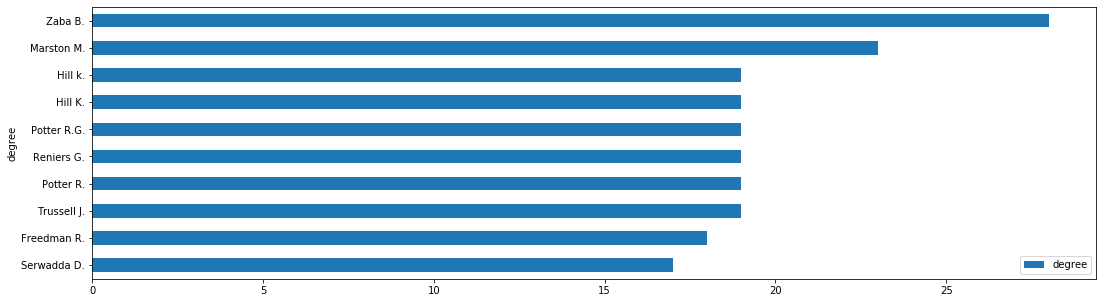

In [4]:

degree_sort = authors_df.sort_values(by=['degree'],ascending=False)[0:10][['indexed_name','degree']]
degree_sort = degree_sort.set_index('indexed_name')
ax = degree_sort.plot.barh(rot=0,figsize=(18,5))
ax.invert_yaxis()  # labels read top-to-bottom
plt.ylabel("degree")
plt.style.use('fivethirtyeight')

In [5]:
degree_sort

,degree
indexed_name,
Zaba B.,28
Marston M.,23
Hill k.,19
Hill K.,19
Potter R.G.,19
Reniers G.,19
Potter R.,19
Trussell J.,19
Freedman R.,18


Text(0, 0.5, 'degree_centrality')

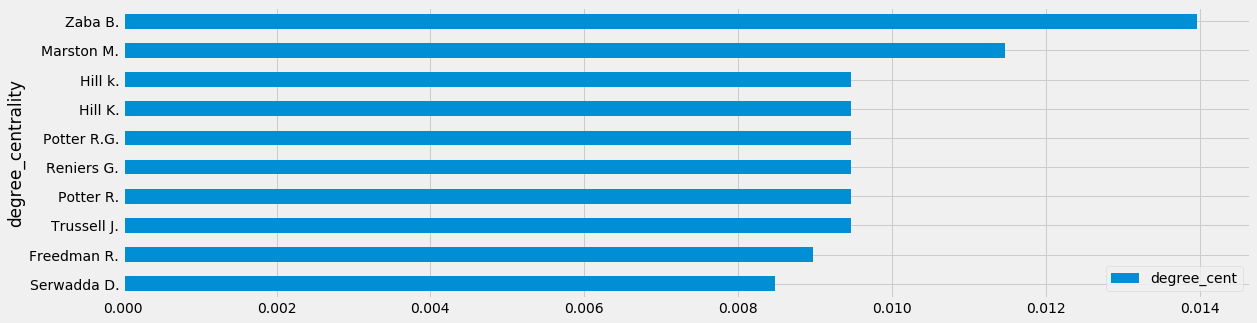

In [6]:
degree_sort = authors_df.sort_values(by=['degree_cent'],ascending=False)[0:10][['indexed_name','degree_cent']]
degree_sort = degree_sort.set_index('indexed_name')
ax = degree_sort.plot.barh(rot=0,figsize=(18,5))
ax.invert_yaxis()  # labels read top-to-bottom
plt.ylabel("degree_centrality")
#plt.style.use('bmh')

Text(0, 0.5, 'degree_centrality')

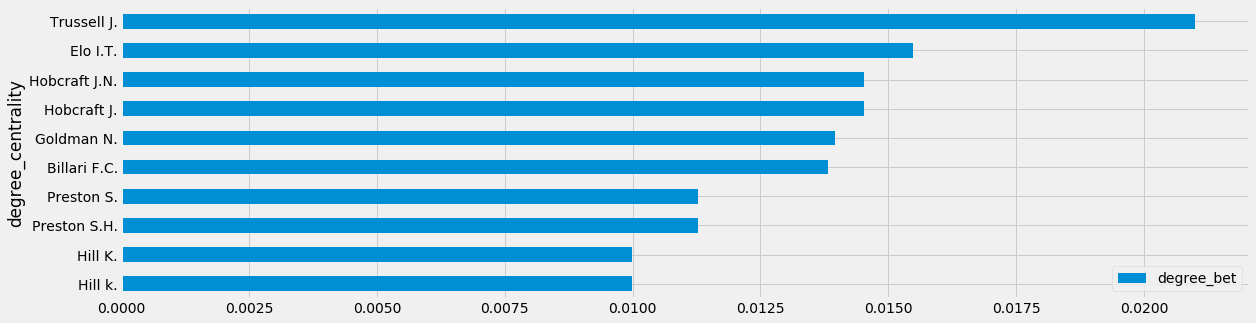

In [7]:
degree_sort = authors_df.sort_values(by=['degree_bet'],ascending=False)[0:10][['indexed_name','degree_bet']]
degree_sort = degree_sort.set_index('indexed_name')
ax = degree_sort.plot.barh(rot=0,figsize=(18,5))
ax.invert_yaxis()  # labels read top-to-bottom
plt.ylabel("degree_centrality")
#plt.style.use('bmh')

In [8]:
print(G.number_of_edges(), G.number_of_nodes(), nx.density(G))

2284 2007 0.0011346131014033137


In [9]:
filterAuthors = dict(zip(authors_df['authorid'].value_counts().keys(),author_papers['authorid'].value_counts().values))
filterAuthors = [authorId for authorId,paperCount in filterAuthors.items() if paperCount>1]

#subnetwork
G1 = G.subgraph([a_int_id[i] for i in filterAuthors])
print(G1.number_of_edges(), G1.number_of_nodes())



233 611


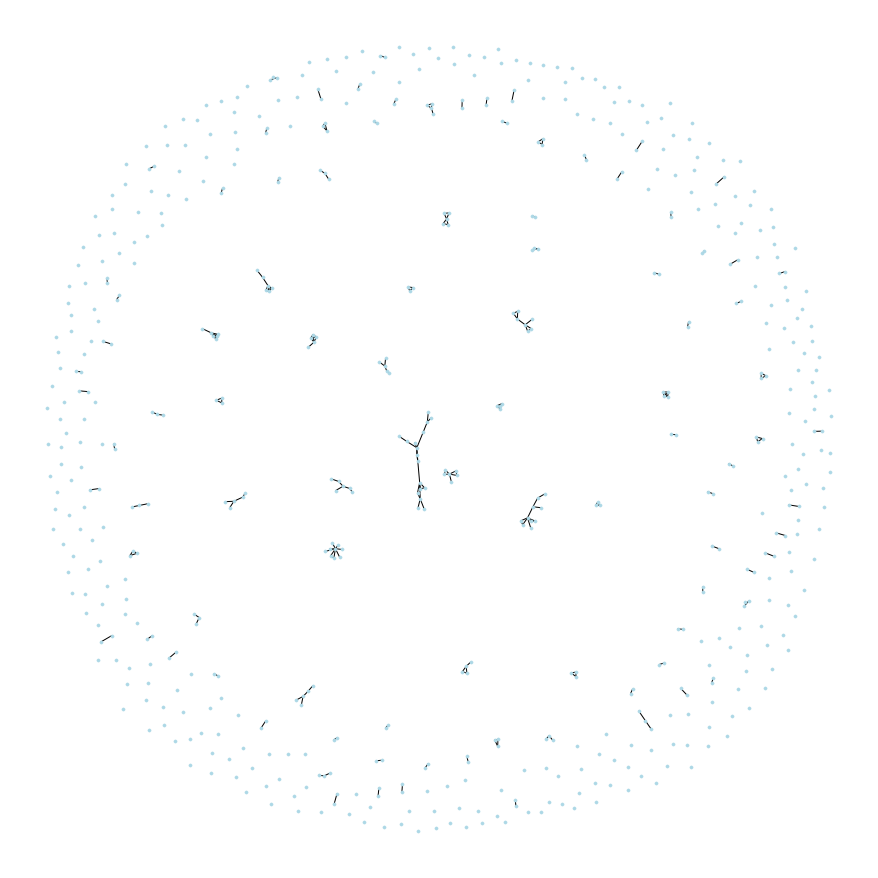

In [10]:
import matplotlib.pyplot as plt
plt.figure(3,figsize=(12,12)) 
nx.draw(G1, with_labels=False, node_size = 10, node_color = 'lightblue')

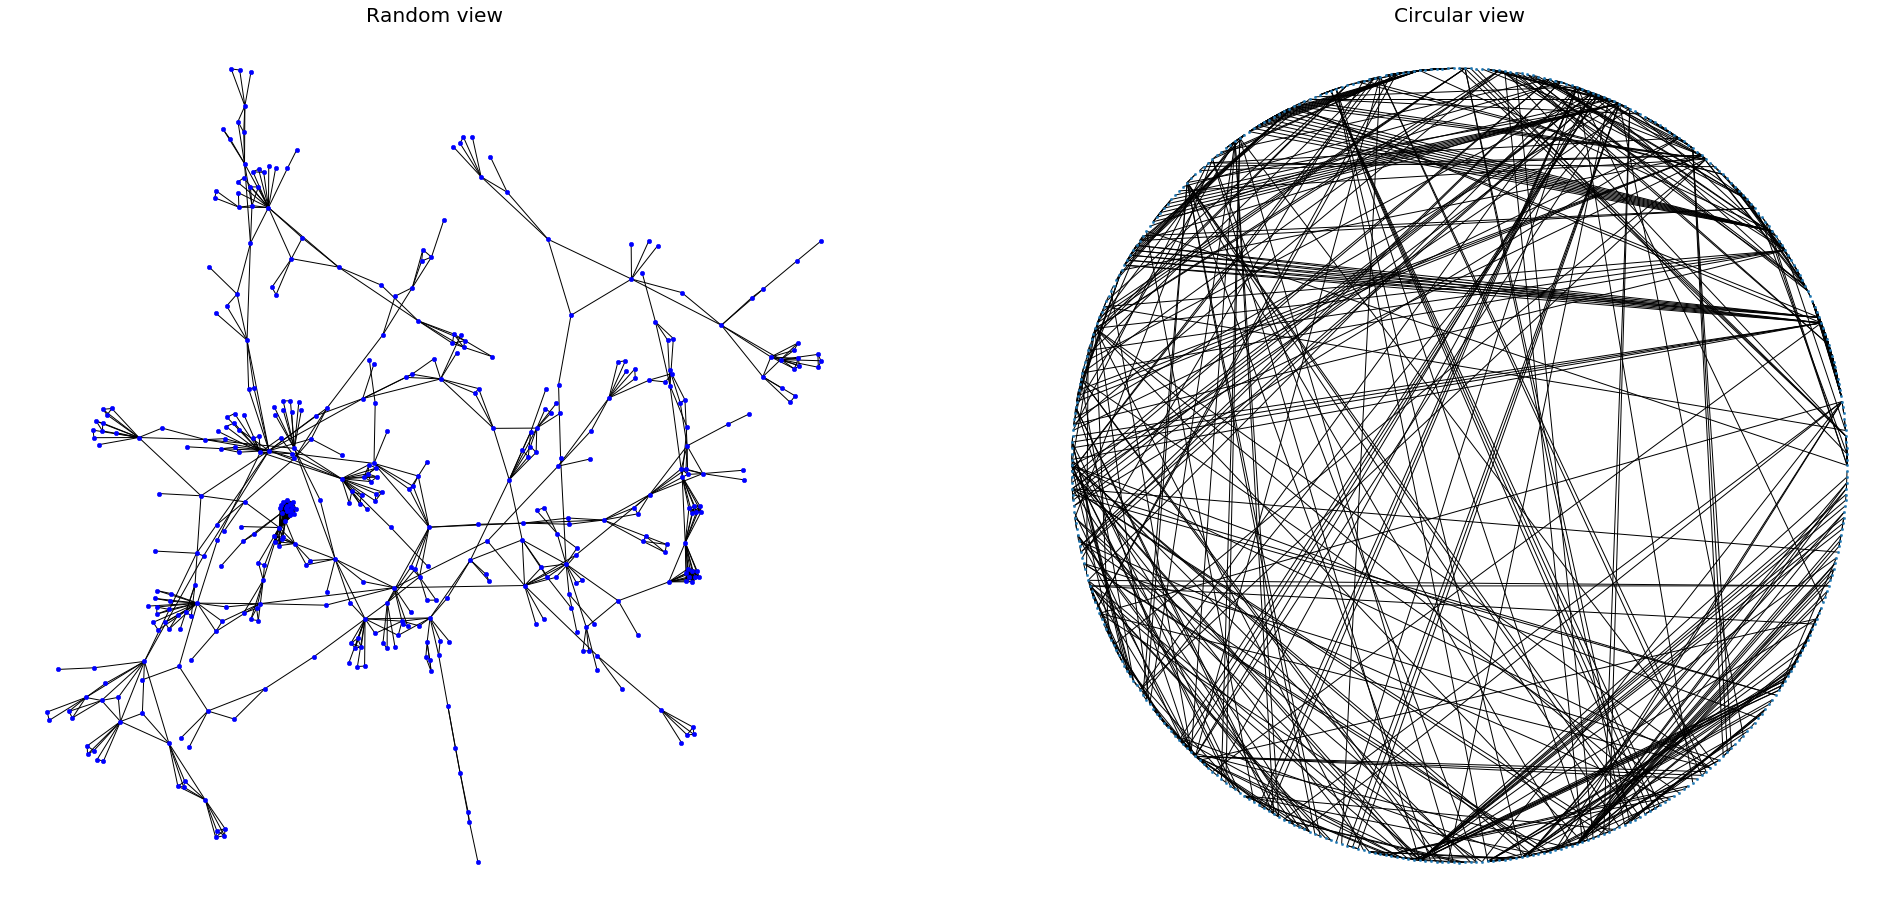

In [11]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
graphs = [G0, G0]
names = ['Random view', 'Circular view']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15))
ax = axes.flatten()
nx.draw(G0, with_labels=False, node_size = 20, node_color = 'b', ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title(names[0])
nx.draw_circular(graphs[1], ax=ax[1], node_size=5)
ax[1].set_axis_off()
ax[1].set_title(names[1])
plt.show()

#4575b4


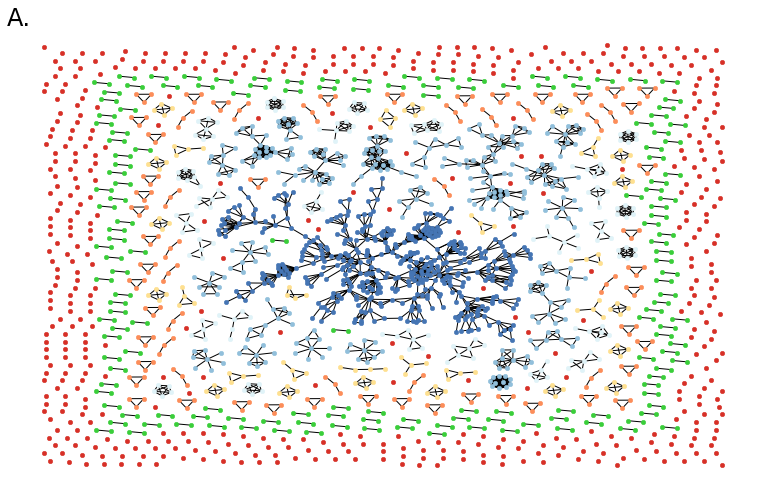

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
# layout graphs with positions using graphviz neato
pos = graphviz_layout(G, prog="neato")
# color nodes the same in each connected subgraph
C = (G.subgraph(c) for c in nx.connected_components(G))
colors1 = ['#d73027', '#3ace3a', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
for g in C:
    c = [random.random()] * nx.number_of_nodes(g)  # random color...
    if nx.number_of_nodes(g) == 1:
        c = colors1[0]
        pass
    elif nx.number_of_nodes(g) == 2:
        c = colors1[1]
    elif nx.number_of_nodes(g) == 3:
        c = colors1[2]
    elif nx.number_of_nodes(g) == 4:
        c = colors1[3]
    elif (nx.number_of_nodes(g)>4) and nx.number_of_nodes(g)<8:
        c = colors1[4]
    elif (nx.number_of_nodes(g)>7) and nx.number_of_nodes(g)<400:
        c = colors1[5]
    elif (nx.number_of_nodes(g)>400):
        c = colors1[6]
    nx.draw(g, pos, node_size=20, node_color=c, vmin=0.0, vmax=1.0, with_labels=False, ax=ax)
ax.set_title('A.', fontsize=24, loc='left', y=0.98, x=0)
fig_path = os.path.join(os.getcwd(), '..', 'article', 'figures')
plt.savefig(os.path.join(fig_path, 'networks.pdf'),
            bbox_inches='tight')
plt.savefig(os.path.join(fig_path, 'networks.png'),
            bbox_inches='tight', dpi=600)
plt.savefig(os.path.join(fig_path, 'networks.svg'),
            bbox_inches='tight')
plt.show()

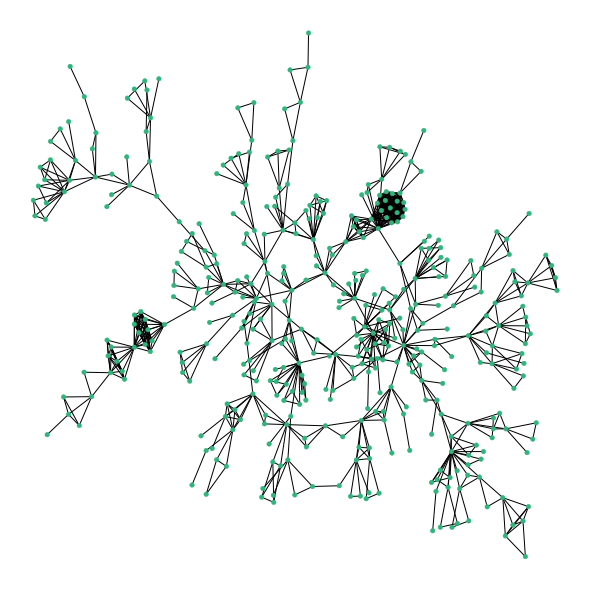

In [13]:
plt.figure(1, figsize=(8, 8))
# layout graphs with positions using graphviz neato
pos = graphviz_layout(G0, prog="neato")
# color nodes the same in each connected subgraph
C = (G0.subgraph(c) for c in nx.connected_components(G0))
for g in C:
    c = [random.random()] * nx.number_of_nodes(g)  # random color...
#    if nx.number_of_nodes(g)> 1:
    nx.draw(g, pos, node_size=20, node_color=c, vmin=0.0, vmax=1.0, with_labels=False)
plt.show()

In [14]:
g

graph has 421 nodes with 807 edges
46 connected components


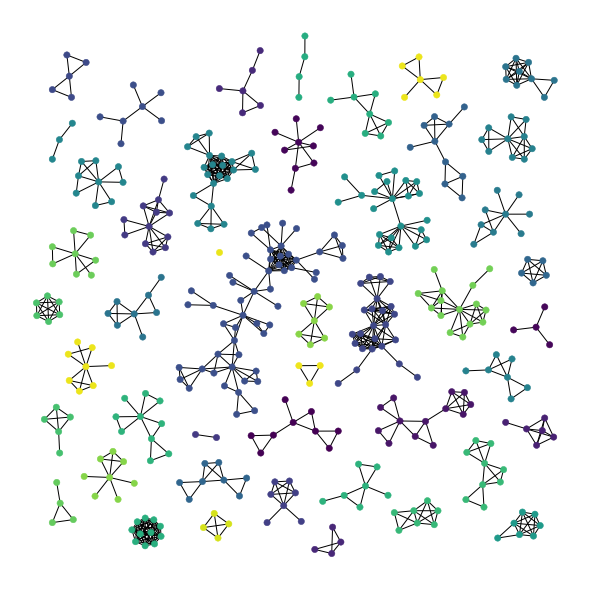

In [15]:
import random

# This example needs Graphviz and either PyGraphviz or pydot.
# from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.isomorphism.isomorph import (
    graph_could_be_isomorphic as isomorphic,
)
from networkx.generators.atlas import graph_atlas_g


def atlas6(G, Gcc):
    """ Return the atlas of all connected graphs of 6 nodes or less.
        Attempt to check for isomorphisms and remove.
    """
    Atlas = []
    for sub in range(1, len(Gcc)):
        Atlas.append(G.subgraph(Gcc[sub]))
    # remove isolated nodes, only connected graphs are left
    U = nx.Graph()  # graph for union of all graphs in atlas
    for g in Atlas:
        zerodegree = [n for n in g if g.degree(n) == 0]
 #       for n in zerodegree:
 #           g.remove_node(n)
        U = nx.disjoint_union(U, g)

    # iterator of graphs of all connected components
    C = (U.subgraph(c) for c in nx.connected_components(U))

    UU = nx.Graph()
    # do quick isomorphic-like check, not a true isomorphism checker
    nlist = []  # list of nonisomorphic graphs
    for g in C:
        # check against all nonisomorphic graphs so far
        if not iso(g, nlist):
            nlist.append(g)
            UU = nx.disjoint_union(UU, g)  # union the nonisomorphic graphs
    return UU


def iso(G1, glist):
    """Quick and dirty nonisomorphism checker used to check isomorphisms."""
    for G2 in glist:
        if isomorphic(G1, G2):
            return True
    return False

G_atlas = atlas6(G, Gcc)

print(f"graph has {nx.number_of_nodes(G_atlas)} nodes with {nx.number_of_edges(G_atlas)} edges")
print(nx.number_connected_components(G_atlas), "connected components")

plt.figure(1, figsize=(8, 8))
# layout graphs with positions using graphviz neato
pos = graphviz_layout(G_atlas, prog="neato")
# color nodes the same in each connected subgraph
C = (G_atlas.subgraph(c) for c in nx.connected_components(G_atlas))
for g in C:
    c = [random.random()] * nx.number_of_nodes(g)  # random color...
    nx.draw(g, pos, node_size=40, node_color=c, vmin=0.0, vmax=1.0, with_labels=False)
plt.show()

In [16]:
mpt = []
mpt.append(G.subgraph(Gcc[1]))

In [17]:
len(Gcc)

805